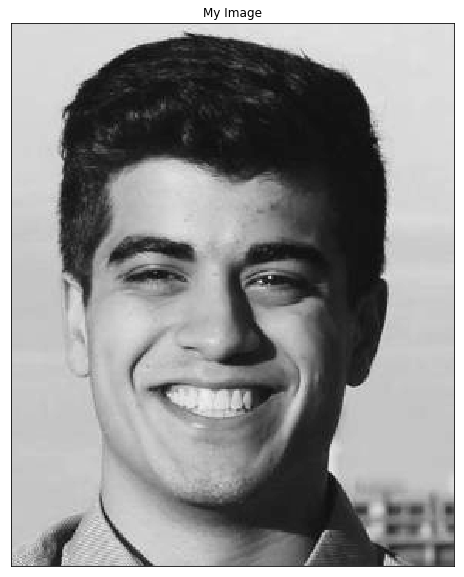

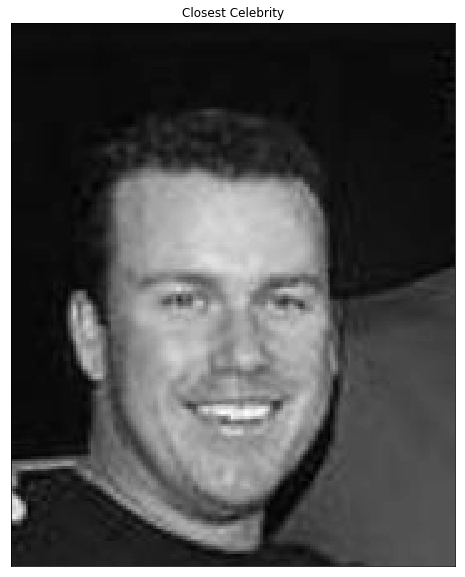

In [5]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import math
from os import listdir


#Calculates LBP value for pixel
def lbpLabelValue(pixelRow, pixelColumn, currentImage):
    centerPixelValue = currentImage[pixelRow][pixelColumn]
    coordinates = [[0, -1], [1, -1], [1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1]]
    labelValue = 0
    for i in range(len(coordinates)):
        currentPixelRow = coordinates[i][0] + pixelRow
        currentPixelColumn = coordinates[i][1] + pixelColumn
        if not (currentPixelRow < 0 or currentPixelRow >= len(currentImage) or currentPixelColumn < 0 or currentPixelColumn >= len(currentImage[0])):
            if(currentImage[currentPixelRow][currentPixelColumn] > centerPixelValue):
                labelValue += math.pow(2, 7-i)
        
    return labelValue

#Finds LBP for full image
def findLbpImage(imageName):
    currentImage = cv2.imread(imageName, cv2.IMREAD_GRAYSCALE)
    resizedImage = cv2.resize(currentImage, (128, 128), interpolation =  cv2.INTER_AREA) 
    lbpImage = np.copy(resizedImage)
    for i in range(len(resizedImage)):
        for j in range(len(resizedImage[i])):
            lbpImage[i][j] = lbpLabelValue(i, j, resizedImage)
    return lbpImage

windowSize = [[0, 17], [18, 35], [36, 53], [54, 71], [72,89], [90, 107], [108, 127]]

#Calculates histograms for individual pictures
def calculateHistograms(lbpImage):
    myImageHistograms = []
    for i in range(len(windowSize)):
        for j in range(len(windowSize)):
            mask = np.zeros((len(lbpImage), len(lbpImage[i])), np.uint8)
            mask[windowSize[i][0]: windowSize[i][1], windowSize[j][0]: windowSize[j][1]] = 255
            histogramForQuadrant = cv2.calcHist([lbpImage], [0], mask, [256], [0,256])
            myImageHistograms.append(cv2.normalize(histogramForQuadrant, None))
    return myImageHistograms

#Creates histogram for my image
myLbpImage = findLbpImage("Myself.jpeg")
myImageHistograms = calculateHistograms(myLbpImage)

def calculateSumOfSquareDifference(listA, listB):
    return np.sum((listA - listB)**2)

fileNames = listdir('img_align_celeb')

currentMinimumSSD = 100;
currentClosestImageName = ''

#Loops over celeb images storing the closest one to variable above
for fileName in fileNames:
    currentLbpImage = findLbpImage('img_align_celeb/' + fileName)
    currentImageHistograms = calculateHistograms(currentLbpImage)
    currentSumOfSquareDifference = 0
    for i in range(len(currentImageHistograms)):
        currentSumOfSquareDifference += calculateSumOfSquareDifference(myImageHistograms[i], currentImageHistograms[i])
    if(currentSumOfSquareDifference < currentMinimumSSD):
        currentMinimumSSD = currentSumOfSquareDifference
        currentClosestImageName = fileName
        
myImg = cv2.imread("Myself.jpeg", cv2.IMREAD_GRAYSCALE)
closestImg = cv2.imread('img_align_celeb/' + currentClosestImageName, cv2.IMREAD_GRAYSCALE)

#Output image of myself
plt.figure(figsize=(10, 10))
plt.title("My Image")
plt.imshow(myImg, cmap="gray")
plt.xticks([]), plt.yticks([]) # remove axes ticks
plt.show() # display plot        

#Output image of closest celebrity
plt.figure(figsize=(10, 10))
plt.title("Closest Celebrity")
plt.imshow(closestImg, cmap="gray")
plt.xticks([]), plt.yticks([]) # remove axes ticks
plt.show() # display plot

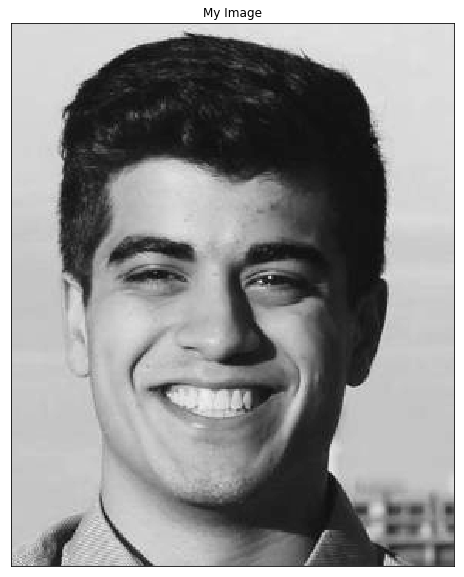

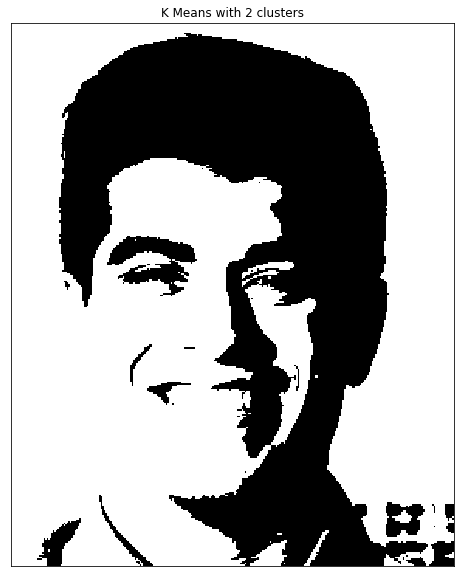

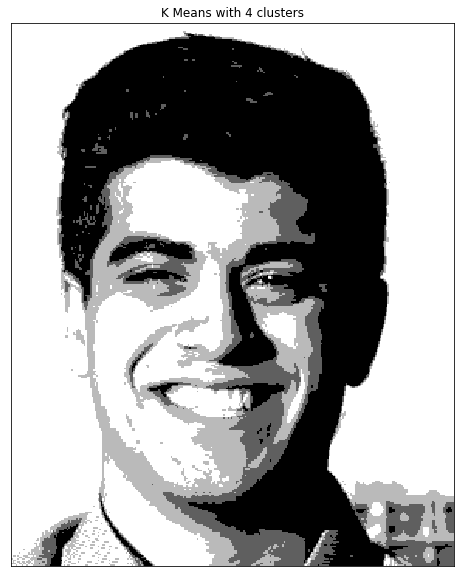

In [8]:
#For this question the K Means algorithm works as expected. The GMM with EM does not work as intended.
#There is an issue during the maximization phase that causes the std deviation to become larger than the dataset

import matplotlib.pyplot as plt
import cv2
import numpy as np
import math
import random
from scipy.stats import norm

image = cv2.imread("Myself.jpeg", cv2.IMREAD_GRAYSCALE)

def calculateGaussian(x, mean, deviation):
    return 1/(math.sqrt(2*math.pi)*deviation)*math.e**(-0.5*(float(x-mean)/deviation)**2)

#Output image without maxima suppression
plt.figure(figsize=(10, 10))
plt.title("My Image")
plt.imshow(image, cmap="gray")
plt.xticks([]), plt.yticks([]) # remove axes ticks
plt.show() # display plot        

clusterCounts = [2, 4]
kMeansClusters = []
kMeansResults = []

#Runs KMeans twice, once for 2 clusters and then for 4 clusters
for numClusters in clusterCounts:
    clusterChange = True
    currentClusters = []
    currentClusterTotal = []
    currentClusterCount = []
    
    #Creates n randome clusters
    for i in range(numClusters):
        currentClusters.append(random.randint(0, 255))
        currentClusterTotal.append(0)
        currentClusterCount.append(0)
    
    #Breaks when clusters converge
    while(clusterChange):
        clusterChange = False
        for i in range(len(image)):
            for j in range(len(image[i])):
                clusterIndex = (np.abs(currentClusters - image[i][j])).argmin()
                currentClusterTotal[clusterIndex] += image[i][j]
                currentClusterCount[clusterIndex] += 1

        for i in range(len(currentClusters)):
            if(currentClusterCount[i] != 0):
                newClusterValue = currentClusterTotal[i]/currentClusterCount[i]
                currentClusterTotal[i] = 0
                currentClusterCount[i] = 0
                if(currentClusters[i] != newClusterValue):
                    currentClusters[i] = newClusterValue      
                    clusterChange = True
                    
    segmentedImage = np.copy(image)
    
    #Applies clustering to the images
    for i in range(len(segmentedImage)):
        for j in range(len(segmentedImage[i])):
            clusterIndex = (np.abs(currentClusters - image[i][j])).argmin()
            segmentedImage[i][j] = currentClusters[clusterIndex]
    
    #Saves clusters to be used by the GMM algorithm
    kMeansClusters.append(currentClusters)
    kMeansResults.append(segmentedImage)
    
    #Output K means image with n clusters
    plt.figure(figsize=(10, 10))
    plt.title("K Means with " + str(numClusters) + " clusters")
    plt.imshow(segmentedImage, cmap="gray")
    plt.xticks([]), plt.yticks([]) # remove axes ticks
    plt.show() # display plot        
    

    
#This is where the GMM and EM algorithm starts, does not converge as intended
currentMeans = [63, 191]
currentStdDev = [128, 128]
currentProbs = [0.5, 0.5]
    
converge = False
while(not converge):
    converge = True
    probPerMean = []

    #Expectation step, finds probability that the pixel is in the cluster
    for index in range(len(currentMeans)):
        probabilities = np.copy(image).astype(np.float32)

        for i in range(len(image)):
            for j in range(len(image[i])):
                probabilityNumerator = currentProbs[index] * calculateGaussian(image[i][j], currentMeans[index], currentStdDev[index])
                probabilityDenominator = 0
                for k in range(len(currentMeans)):
                    probabilityDenominator += currentProbs[k] * calculateGaussian(image[i][j], currentMeans[k], currentStdDev[k])
                probabilities[i][j] = probabilityNumerator/probabilityDenominator
                
        probPerMean.append(probabilities)
    
    #Maximization step, recalculates mean, probabilities and std deviation
    for index in range(len(currentMeans)):
        sumOfProbs = 0
        sumOfXProbs = 0
        sumOfXMeanProbs = 0
        N = 0
        for i in range(len(probPerMean[index])):
            for j in range(len(probPerMean[index][i])):
                sumOfProbs += probPerMean[index][i][j]
                sumOfXProbs += probPerMean[index][i][j] * image[i][j]
                sumOfXMeanProbs += probPerMean[index][i][j] * (image[i][j]-currentMeans[index])**2
                N += 1
        
        if(currentProbs[index] != sumOfProbs/N):
            currentProbs[index] = sumOfProbs/N
            converge = False
        if(currentMeans[index] != sumOfXProbs/sumOfProbs):
            currentMeans[index] = sumOfXProbs/sumOfProbs
            converge = False
        if(currentStdDev[index] != sumOfXMeanProbs/sumOfProbs):
            currentStdDev[index] = sumOfXMeanProbs/sumOfProbs
            converge = False

